In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load Dataset

In [2]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [3]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [4]:
df_raw.dtypes

EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                                 int64
dtype: object

In [5]:
df = df_raw.copy()
_ = df.pop("Rating")
df.shape

(499, 12)

In [6]:
X = df.values
X.shape

(499, 12)

---

### HDBSCAN

In [7]:
def remove_outliers(data: list, labels: list[int]) -> tuple:
    outlier_indexes = [index for index, label in enumerate(labels) if label == -1]
    updated_data = [data_row for index, data_row in enumerate(data) if index not in outlier_indexes]
    updated_labels = [label for index, label in enumerate(labels) if index not in outlier_indexes]
    return np.array(updated_data), updated_labels

In [8]:
# Hyperparameters
min_cluster_size_values = np.arange(5, 26)
max_cluster_size_values = np.arange(100, 251, 50) # [100, 150, 200, 250]
# cluster_selection_epsilon_values

hdbscan_hyperparameters = list(itertools.product(*[min_cluster_size_values, max_cluster_size_values]))

In [9]:
models = []
clusters = []
total_clusters = []
silhouette_values = []
calinski_harabasz_values = []
davies_bouldin_values = []

for hyperparameters_set in tqdm(hdbscan_hyperparameters):
    try:
        min_cluster_size_value = hyperparameters_set[0]
        max_cluster_size_value = hyperparameters_set[1]
        hdbscan = HDBSCAN(min_cluster_size=min_cluster_size_value, max_cluster_size=max_cluster_size_value, n_jobs=-1).fit(X)
        labels = list(hdbscan.labels_)
        clusters.append(labels)
        
        updated_data, updated_labels = remove_outliers(X, labels)

        # store model and labels (different from -1)
        models.append(hdbscan)
        total_clusters.append(len(np.unique(updated_labels)))
        
        # calculate metrics
        silhouette_values.append(round(silhouette_score(updated_data, updated_labels), 3))
        calinski_harabasz_values.append(round(calinski_harabasz_score(updated_data, updated_labels), 3))
        davies_bouldin_values.append(round(davies_bouldin_score(updated_data, updated_labels), 3))
    
    except Exception as e:
        print(f"Exception -> {e}")
        silhouette_values.append(-1)
        calinski_harabasz_values.append(-1)
        davies_bouldin_values.append(-1)
    

100%|██████████| 84/84 [00:03<00:00, 27.40it/s]


In [10]:
len(silhouette_values), len(calinski_harabasz_values), len(davies_bouldin_values)

(84, 84, 84)

Text(0.5, 1.0, 'Clusters Validation (Silhouette Coefficient)')

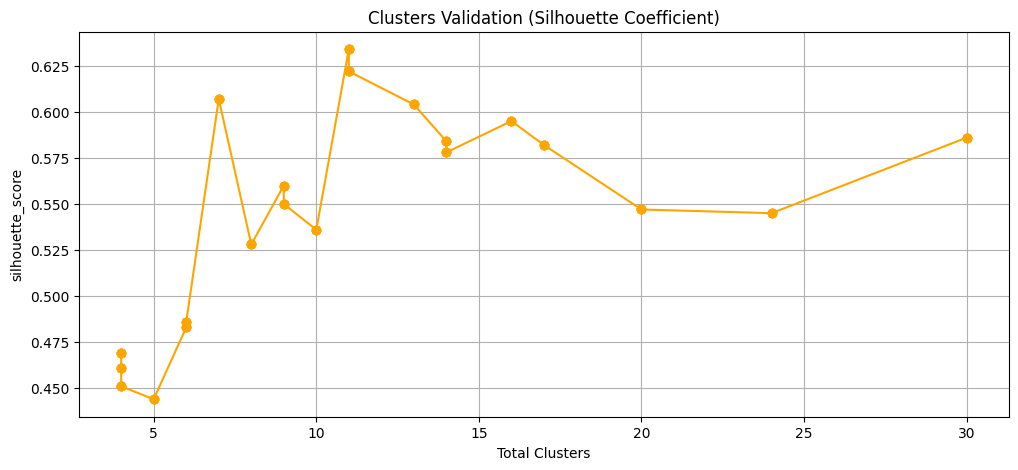

In [12]:
plt.figure(figsize=(12, 5), dpi=100)
plt.grid()
plt.plot(total_clusters, silhouette_values, marker='o', color="orange") # Better defined clusters
plt.xlabel("Total Clusters")
plt.ylabel("silhouette_score")
plt.title("Clusters Validation (Silhouette Coefficient)")

In [13]:
best_silhouette_value_index = np.argmax(silhouette_values) # The higher the better
print(f"Best Model: {models[best_silhouette_value_index]} | score: {silhouette_values[best_silhouette_value_index]} | clusters: {total_clusters[best_silhouette_value_index]}")

Best Model: HDBSCAN(max_cluster_size=100, min_cluster_size=14, n_jobs=-1) | score: 0.634 | clusters: 11


Text(0.5, 1.0, 'Clusters Validation (Calinski-Harabasz)')

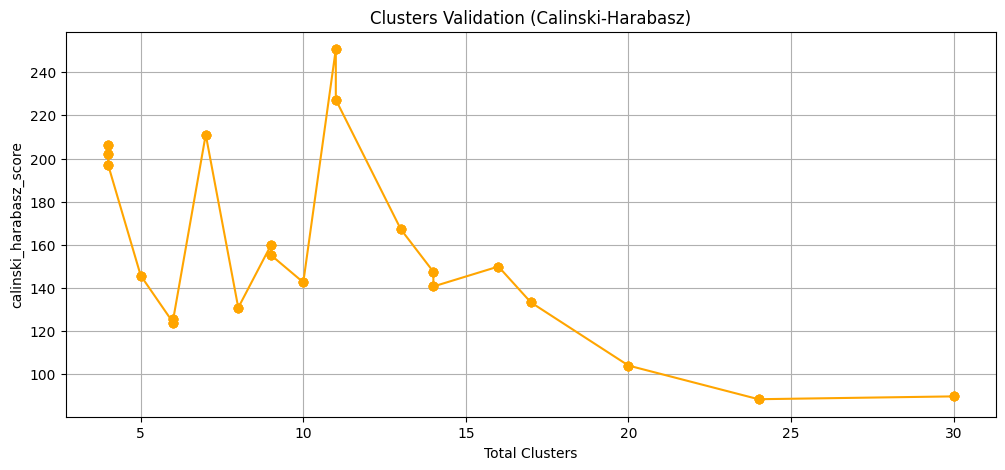

In [14]:
plt.figure(figsize=(12, 5), dpi=100)
plt.grid()
plt.plot(total_clusters, calinski_harabasz_values, marker='o', color="orange") # Better defined clusters
plt.xlabel("Total Clusters")
plt.ylabel("calinski_harabasz_score")
plt.title("Clusters Validation (Calinski-Harabasz)")

In [15]:
best_calinsky_harabasz_value_index = np.argmax(calinski_harabasz_values) # The higher the better
print(f"Best Model: {models[best_calinsky_harabasz_value_index]} | score: {calinski_harabasz_values[best_calinsky_harabasz_value_index]} | clusters: {total_clusters[best_calinsky_harabasz_value_index]}")

Best Model: HDBSCAN(max_cluster_size=100, min_cluster_size=14, n_jobs=-1) | score: 250.644 | clusters: 11


Text(0.5, 1.0, 'Clusters Validation (Davies-Bouldin)')

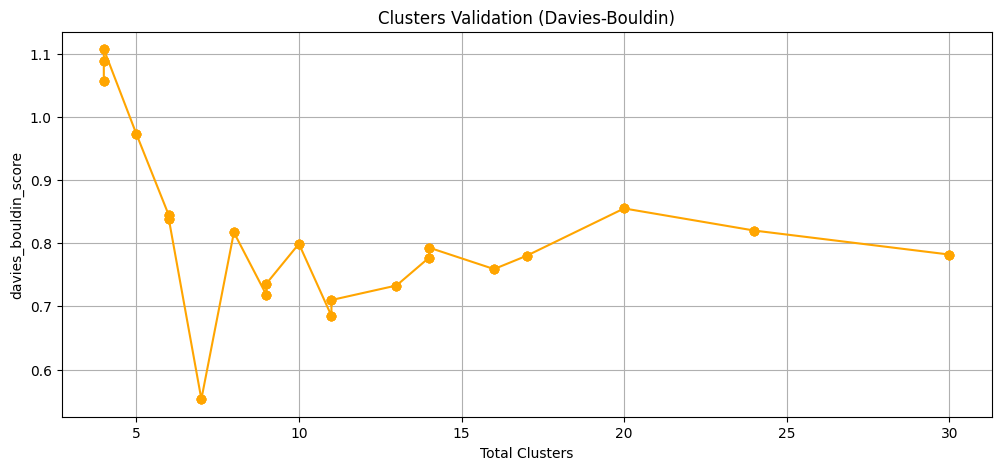

In [16]:
plt.figure(figsize=(12, 5), dpi=100)
plt.grid()
plt.plot(total_clusters, davies_bouldin_values, marker='o', color="orange") # Better separation between clusters
plt.xlabel("Total Clusters")
plt.ylabel("davies_bouldin_score")
plt.title("Clusters Validation (Davies-Bouldin)")

In [17]:
best_davies_bouldin_value_index = np.argmin(davies_bouldin_values) # The lower the better
print(f"Best Model: {models[best_davies_bouldin_value_index]} | score: {davies_bouldin_values[best_davies_bouldin_value_index]} | clusters: {total_clusters[best_davies_bouldin_value_index]}")

Best Model: HDBSCAN(max_cluster_size=100, min_cluster_size=19, n_jobs=-1) | score: 0.553 | clusters: 7


### Clusters (and Outliers) Analysis

In [19]:
best_combination_index = best_silhouette_value_index
best_combination_index

36

In [20]:
best_hdbscan = models[best_combination_index]
best_hdbscan

HDBSCAN(max_cluster_size=100, min_cluster_size=14, n_jobs=-1)

In [21]:
cluster_labels = clusters[best_combination_index]
len(cluster_labels), cluster_labels[:5]

(499, [9, 4, -1, 7, 3])

In [23]:
df_labels = df_raw.copy()
df_labels.insert(df_labels.shape[1], "cluster", cluster_labels)
df_labels

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating,cluster
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5,9
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1,-1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5,7
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.699490,1.385178,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,4,8
495,-0.792157,-1.453442,0.897597,1.112064,-1.472057,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,2,-1
496,1.445313,1.385178,-0.099400,0.049436,-0.062160,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5,-1
497,-1.537981,1.385178,0.872672,0.765484,-1.472057,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5,-1


In [25]:
df_labels.groupby("cluster").size()

cluster
-1     223
 0      16
 1      31
 2      26
 3      23
 4      34
 5      31
 6      26
 7      14
 8      32
 9      25
 10     18
dtype: int64